## 4.2 Naive Bayes

Import necessary libraries to perform Naive Bayes Classification.

In [28]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from joblib import load

### 1. Data Prep for ML

Unpickle data and remove any NA values.

Concate "comment" and "parent_comment" for TF-IDF and BoW from training and testing datasets using vstack.

In [29]:
train = pd.read_pickle("data/train.pkl").dropna()
test = pd.read_pickle("data/test.pkl").dropna()
tfidf_vec = load('tdvectorizer.pkl')

In [30]:
train_parent_tfidf_csr = vstack(train["parent_comment_tfidf"])
test_parent_tfidf_csr = vstack(test["parent_comment_tfidf"])

train_tfidf_csr = vstack(train["comment_tfidf"])
test_tfidf_csr = vstack(test["comment_tfidf"])

train_parent_bow_csr = vstack(train["parent_comment_bow"])
test_parent_bow_csr = vstack(test["parent_comment_bow"])

train_bow_csr = vstack(train["comment_bow"])
test_bow_csr = vstack(test["comment_bow"])

In [31]:
train.columns

Index(['comment', 'parent_comment', 'comment_tokens', 'parent_comment_tokens',
       'comment_score', 'parent_comment_score',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive', 'comment_word_count',
       'parent_comment_word_count', 'comment_token_count',
       'parent_comment_token_count', 'comment_unique_word_count',
       'parent_comment_unique_word_count', 'comment_unique_token_count',
       'parent_comment_unique_token_count', 'comment_stopword_count',
       'parent_comment_stopword_count', 'comment_mean_word_length',
       'parent_comment_mean_word_length', 'comment_mean_token_length',
       'parent_comment_mean_token_length', 'comment_char_count',
       'parent_comment_char_count', 'comment_punctuation_count',
       'parent_comment_punctuation_count', 'comment_hashtag_count',
       'parent_comment_hashtag_count', 'co

List of features necessary for Naive Bayes classification.

In [32]:
list_of_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive']

Here we will standardize columns with boolean values. We will change from boolean to integer type and convert the features from a dense matrix to a sparse matrix using the function csr_matrix.

In [33]:
bool_cols = ['weighted_parent_sentiment_score_neutral',
             'weighted_parent_sentiment_score_positive',
             'weighted_comment_sentiment_score_neutral',
             'weighted_comment_sentiment_score_positive']

for col in bool_cols: #need to convert bool type to integer
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)
X_train_gen_features = csr_matrix(train[list_of_features])
y_train_LR = train['label']

X_test_gen_features = csr_matrix(test[list_of_features])
y_test_LR = test['label']

### 2. Base Model
Using Baseline 5: General Features + TF-IDF

In [34]:
X_train_LR = hstack([X_train_gen_features,train_tfidf_csr])

Running 5-fold cross validation

In [35]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.6503701473822073
Standard Deviation of roc_auc: 0.011577166779132446


Evaluating Base model on Test Set

In [36]:
# Train Baseline Model on whole training set
model = MultinomialNB()
model.fit(X_train_LR, y_train_LR)

# Evaluate AUC_ROC
X_test_LR = hstack([X_test_gen_features,test_tfidf_csr])
y_pred_test = model.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.6560532788161504


ROC curve on Test set

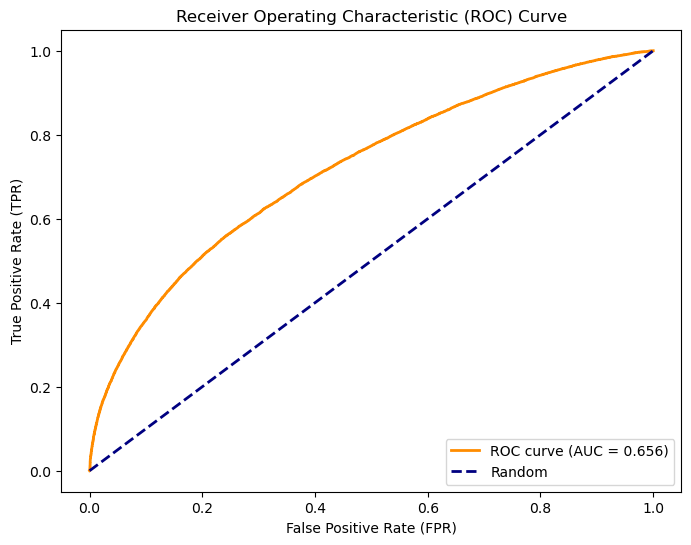

In [37]:
# Obtain Probability Scores
y_scores = model.predict_proba(X_test_LR)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_LR, y_scores)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.3f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Model Explanability

[[ -3.45361018  -2.62811414  -3.8715834  ... -17.25651067 -16.55837674
  -16.62478455]
 [ -3.47065283  -2.63718436  -3.88684092 ... -16.36267968 -16.65101671
  -16.64875301]]


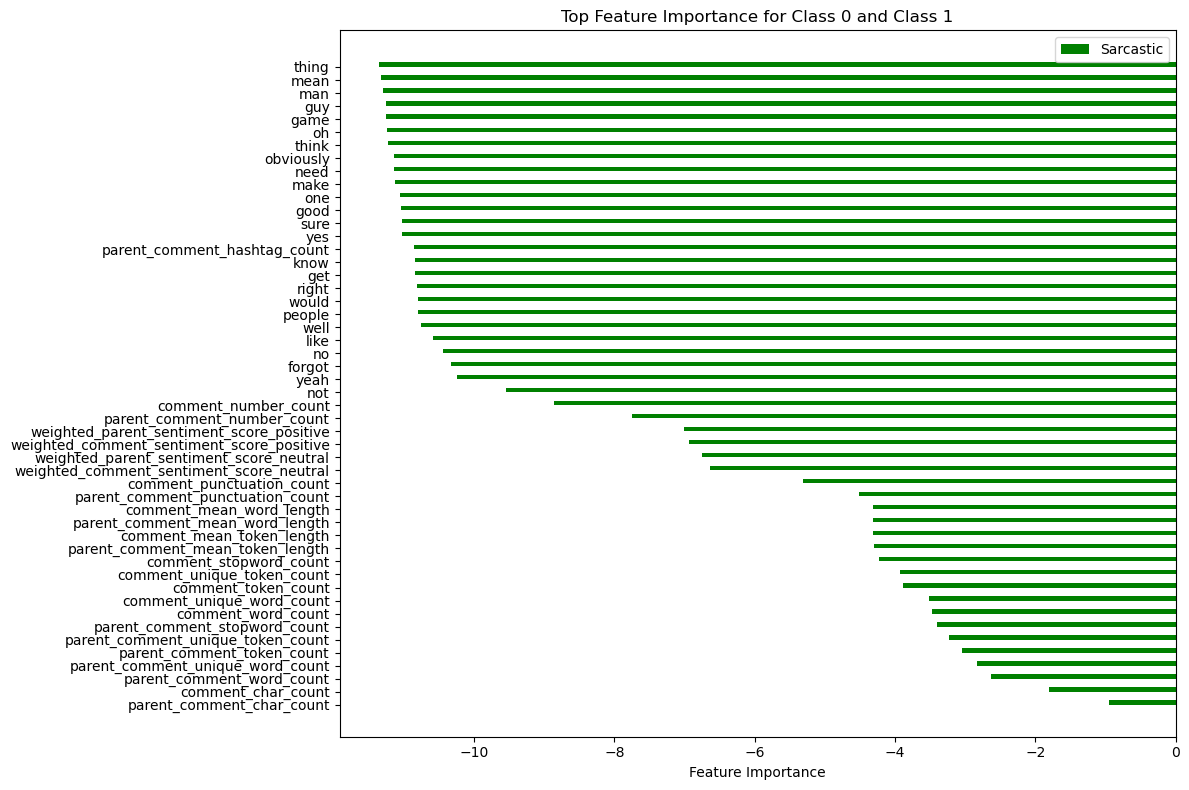

In [41]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_
general_features = list_of_features
ngrams_features = tfidf_vec.get_feature_names_out()
feature_names = list_of_features + list(ngrams_features)

# Mapping feature names to importance scores
feature_importance_dict1 = dict(zip(feature_names, feature_log_prob[1]))

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = 50 # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = 50
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='Sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_1)
plt.legend()
plt.tight_layout()
plt.show()

### 3. Hyper Parameter Tuning with Grid Search CV

Baseline 5: General Features + BoW has the highest mean roc_auc score (0.63460). This means that it is the best performing classifier. We will now perform hyperparameter tuning on this to increase the model performance. We will use GridSearchCV to cross validate all possible hyperparameter combinations and pick the best performing hyperparameters.

In [42]:
### Using gen features and bow
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [43]:
param_grid = {
    'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],  # You can extend this list
    'fit_prior': [True, False],
}

In [44]:
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='roc_auc', verbose=4)
grid_search.fit(X_train_LR, y_train_LR)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .........alpha=0.2, fit_prior=True;, score=0.708 total time=   0.1s
[CV 2/5] END .........alpha=0.2, fit_prior=True;, score=0.709 total time=   0.0s
[CV 3/5] END .........alpha=0.2, fit_prior=True;, score=0.716 total time=   0.0s
[CV 4/5] END .........alpha=0.2, fit_prior=True;, score=0.715 total time=   0.1s
[CV 5/5] END .........alpha=0.2, fit_prior=True;, score=0.707 total time=   0.0s
[CV 1/5] END ........alpha=0.2, fit_prior=False;, score=0.708 total time=   0.1s
[CV 2/5] END ........alpha=0.2, fit_prior=False;, score=0.709 total time=   0.0s
[CV 3/5] END ........alpha=0.2, fit_prior=False;, score=0.716 total time=   0.0s
[CV 4/5] END ........alpha=0.2, fit_prior=False;, score=0.715 total time=   0.0s
[CV 5/5] END ........alpha=0.2, fit_prior=False;, score=0.707 total time=   0.0s
[CV 1/5] END .........alpha=0.4, fit_prior=True;, score=0.712 total time=   0.0s
[CV 2/5] END .........alpha=0.4, fit_prior=True;

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc', verbose=4)

In [45]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best score achieved during grid search
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'alpha': 1.0, 'fit_prior': True}
Best Score: 0.7206532170143333


Here we will test out the model using the best hyperparameters.

In [46]:
# Best estimator (the fitted model with the best parameters)
best_estimator = grid_search.best_estimator_
print("Best Estimator:", best_estimator)

# Results for all parameter combinations
cv_results = grid_search.cv_results_

Best Estimator: MultinomialNB()


In [47]:
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

pd.set_option('display.max_colwidth',None)
results_df = pd.DataFrame({'Params':params,'Mean Score':mean_test_scores,'STD':std_test_scores})
results_df["Params"] = results_df["Params"].apply(lambda x: ', '.join([f'{key}: {value}' for key, value in x.items()]))
results_df.sort_values('STD', inplace=True)
results_df.sort_values('Mean Score', ascending=False,inplace=True)
results_df


#for mean_score, std_score, param in zip(mean_test_scores, std_test_scores, params):
    #print(f"Mean Score: {mean_score:.3f} (±{std_score:.3f}) for params: {param}")

,Params,Mean Score,STD
8,"alpha: 1.0, fit_prior: True",0.720653,0.004744
9,"alpha: 1.0, fit_prior: False",0.720653,0.004744
6,"alpha: 0.8, fit_prior: True",0.719679,0.004573
7,"alpha: 0.8, fit_prior: False",0.719679,0.004573
4,"alpha: 0.6, fit_prior: True",0.718225,0.004375
5,"alpha: 0.6, fit_prior: False",0.718225,0.004375
2,"alpha: 0.4, fit_prior: True",0.715856,0.004131
3,"alpha: 0.4, fit_prior: False",0.715856,0.004131
0,"alpha: 0.2, fit_prior: True",0.711252,0.003776
1,"alpha: 0.2, fit_prior: False",0.711252,0.003776


Evaluating Optimized Model on test set

In [48]:
# Evaluate AUC_ROC
X_test_LR = hstack([X_test_gen_features,test_bow_csr])
y_pred_test = best_estimator.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.6675986922684967


ROC Curve on test set

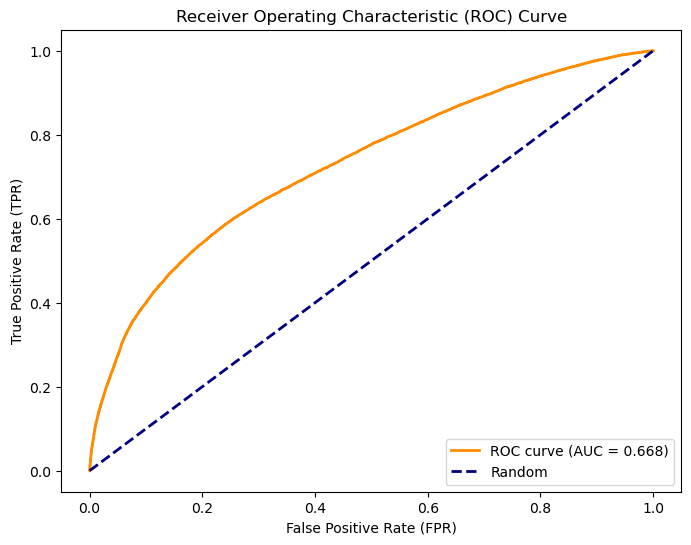

In [49]:
# Obtain Probability Scores
y_scores = best_estimator.predict_proba(X_test_LR)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_LR, y_scores)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.3f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Model Explanability

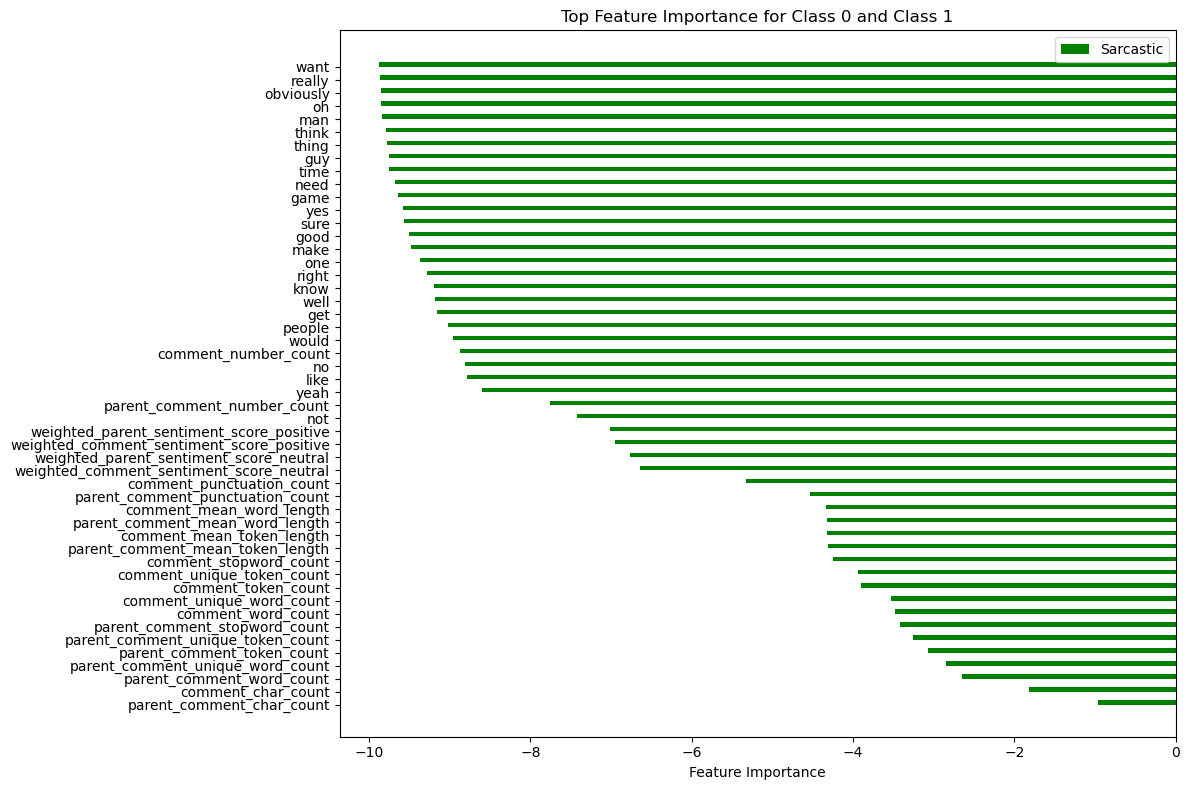

In [51]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = best_estimator.feature_log_prob_
general_features = list_of_features
ngrams_features = tfidf_vec.get_feature_names_out()
feature_names = list_of_features + list(ngrams_features)

# Mapping feature names to importance scores
feature_importance_dict1 = dict(zip(feature_names, feature_log_prob[1]))

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = 50 # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = 50
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='Sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_1)
plt.legend()
plt.tight_layout()
plt.show()